<a href="https://colab.research.google.com/github/goussssss/sketch-to-image-ControlNet/blob/main/sketch_to_image_ControlNet_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --force-reinstall huggingface_hub==0.15.1

  Using cached huggingface_hub-0.15.1-py3-none-any.whl.metadata (8.0 kB)
  Using cached filelock-3.18.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached fsspec-2025.3.0-py3-none-any.whl.metadata (11 kB)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached PyYAML-6.0.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.1 kB)
  Using cached typing_extensions-4.12.2-py3-none-any.whl.metadata (3.0 kB)
  Using cached packaging-24.2-py3-none-any.whl.metadata (3.2 kB)
  Using cached charset_normalizer-3.4.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (35 kB)
  Using cached idna-3.10-py3-none-any.whl.metadata (10 kB)
  Using cached urllib3-2.3.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached certifi-2025.1.31-py3-none-any.whl.metadata (2.5 kB)
Using cached huggingface_hub-0.15.1-py3-none-any.whl (236 kB)
Using cached packaging-24.2-py3-none-any.whl (65 kB)
Us

In [ ]:
!pip install diffusers==0.21.4 transformers==4.30.2 accelerate==0.21.0 controlnet-aux==0.0.6 opencv-python matplotlib

In [ ]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
from diffusers.utils import load_image

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [ ]:
controlnet = ControlNetModel.from_pretrained(
    "lllyasviel/sd-controlnet-scribble",
    torch_dtype=torch.float16
)

In [ ]:
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    controlnet=controlnet,
    safety_checker=None,
    torch_dtype=torch.float16
)


Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [ ]:
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

In [ ]:
pipe = pipe.to(device)

In [ ]:
try:
    pipe.enable_xformers_memory_efficient_attention()
    print("Using xformers for memory efficient attention")
except:
    print("Xformers not available, using default attention mechanism")

Xformers not available, using default attention mechanism


In [ ]:
def prepare_sketch(image_path):
    # Load the image
    if image_path.startswith('http'):
        image = load_image(image_path)
    else:
        image = Image.open(image_path)

    # Resize image to suitable dimensions
    image = image.resize((512, 512))

    # Convert to RGB if needed
    if image.mode != "RGB":
        image = image.convert("RGB")

    return image


In [ ]:
def generate_from_sketch(sketch_path, prompt, negative_prompt="", num_images=1, guidance_scale=9.0, num_inference_steps=30):
    """
    Generate images from sketch

    Parameters:
    - sketch_path: Path to the sketch image file or URL
    - prompt: Text description to guide the image generation
    - negative_prompt: Things to avoid in the generated image
    - num_images: Number of images to generate
    - guidance_scale: How closely to follow the prompt (higher = more faithful)
    - num_inference_steps: Number of denoising steps (higher = better quality but slower)
    """
    sketch_image = prepare_sketch(sketch_path)

    # Generate images
    images = pipe(
        prompt,
        sketch_image,
        negative_prompt=negative_prompt,
        num_images_per_prompt=num_images,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale
    ).images

    # Display results
    plt.figure(figsize=(15, 10))

    # Show original sketch
    plt.subplot(1, num_images + 1, 1)
    plt.imshow(sketch_image)
    plt.title("Original Sketch")
    plt.axis("off")

    # Show generated images
    for i, img in enumerate(images):
        plt.subplot(1, num_images + 1, i + 2)
        plt.imshow(img)
        plt.title(f"Generated Image {i+1}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

    return images

In [ ]:
from google.colab import files
print("Please upload your sketch image:")
uploaded = files.upload()
sketch_path = next(iter(uploaded.keys()))

Please upload your sketch image:


Saving doremon.jpeg to doremon (1).jpeg


  0%|          | 0/30 [00:00<?, ?it/s]

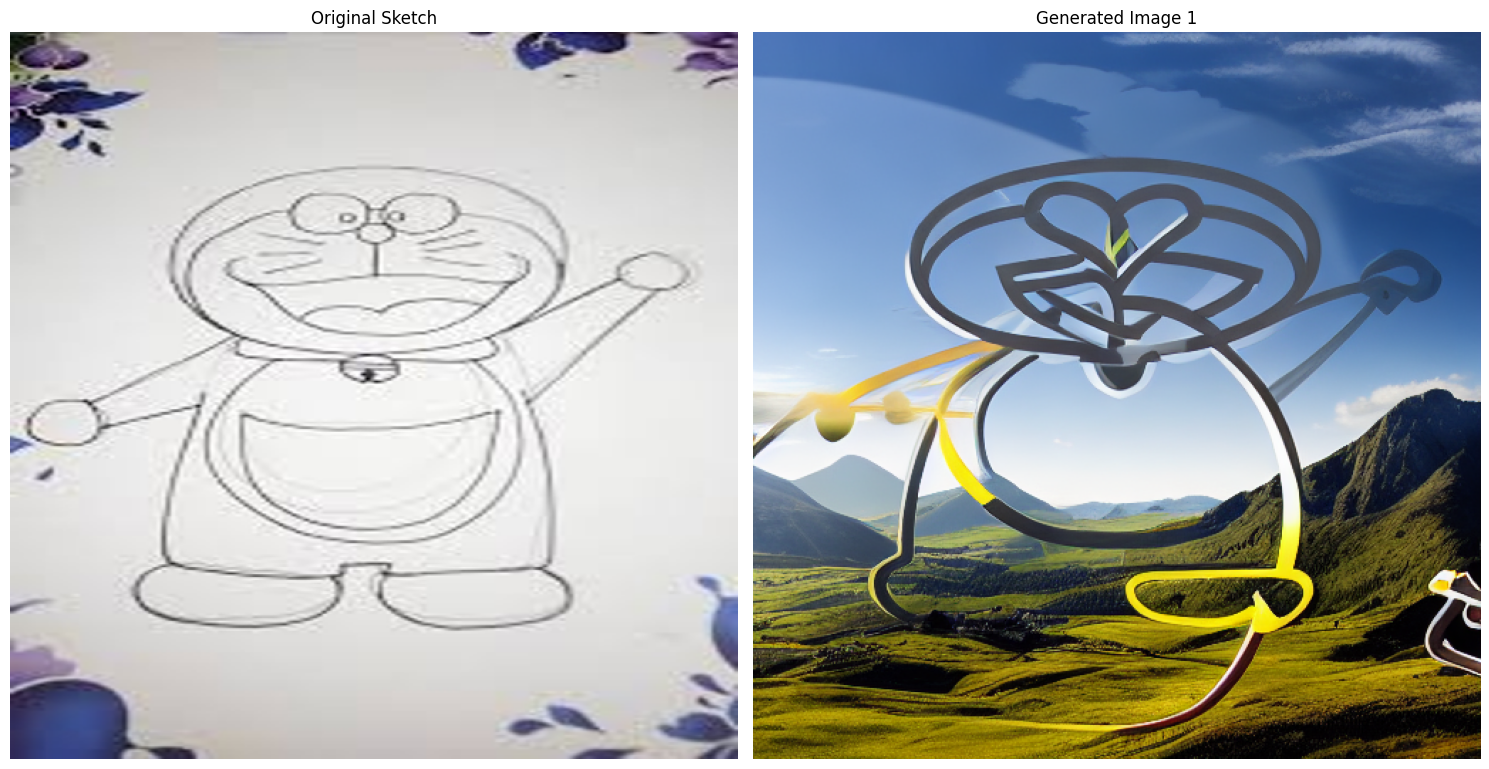

In [ ]:
prompt = "generate a good image from the file upload as context"
negative_prompt = "ugly, deformed, noisy, blurry, distorted, disfigured"

generated_images = generate_from_sketch(
    sketch_path=sketch_path,
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_images=1,
    guidance_scale=9.0,
    num_inference_steps=30
)

In [ ]:
l